# COVID-19
--- 
### Country similarities

The aim of this notebook is to find similarities between country spread growth. The analysis is using the data provided by the Kaggle spread prediction competiton and some additional source for providing the country details. 

In [6]:
import os
import time
import warnings 
import statistics

import numpy   as np 
import pandas  as pd
import seaborn as sns

from matplotlib    import pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics       import mean_squared_log_error

from IPython.display  import display_html 
from pandas_profiling import ProfileReport

from core.networks  import BasicRecurrentPredictor
from core.nn        import WeightInitializer

import torch
from torch import nn
from torch import optim

warnings.filterwarnings('ignore')
sns.set()

torch.manual_seed(123);
torch.cuda.manual_seed(123)
np.random.seed(123)

Load the training data from kaggle data.

In [2]:
trainData = pd.read_csv('assets/train.csv', parse_dates=['Date'])

In [3]:
def preprocess_train(df):

    # fill the state field with name of the country (if it is null)
    renameState     = df['Province_State'].fillna(0).values
    renameCountries = df['Country_Region'].values
    renameState[renameState == 0] = renameCountries[renameState == 0]
    df['Province_State'] = renameState

    return df

In [4]:
trainData = preprocess_train(trainData)

In [5]:
trainData.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,Afghanistan,2020-01-22,0.0,0.0
1,2,Afghanistan,Afghanistan,2020-01-23,0.0,0.0
2,3,Afghanistan,Afghanistan,2020-01-24,0.0,0.0
3,4,Afghanistan,Afghanistan,2020-01-25,0.0,0.0
4,5,Afghanistan,Afghanistan,2020-01-26,0.0,0.0


Because the purpose of this notebook is note to explore the data, just an overview using pandas profiling is provided.

In [6]:
profile = ProfileReport(trainData, title='Growth report', html={'style':{'full_width':True}}, progress_bar=False)
profile.to_widgets()

## 1. Curve matching country similarity

This section will analyze the simmilarities of countries by simply comparing their growth considering multiple errors just from the point of view of deseas spread evolution. 

The comparison will be dealt by making comparison and **alignment point**. The alignment point is a threshod from when we can consider that the pandamy has start spreading in a specific/particular country.

### 1.1 Errors 

#### 1.1.1 L1 normalized error

Return the mean normalized error relative to the source.


In [7]:
def l1_norm_error(source, candidate):
    error = (abs(source - candidate))
    
    # can not divide by 0, add for numerical stability
    source[source == 0] = 1e-30
    
    # compute the percentage
    error = error/source
    error = error.mean()
    
    return error

#### 1.1.4 Root Mean Squared Log Error

Evaluation metric Kaggles's COVID-19 spread prediction.

In [8]:
def rmsle_error(source, candidate):
    candidate += 1e-30
    error  = np.log10((source+1)/(candidate+1))
    error  = error * error
    error  = error.mean()
    error  = np.sqrt(error) 
    
    return error

### 1.2 Comparing data 

In order to find similarities between countries we compare the source country data with the target country in a sliding window manner. In the case that the target data has not enough samples, it's safe to asume that the countries are not alike and that it can be ignored. 

The functin will return the minimum error and the index from where that(the 2 sequence from source and target countries) is.

In [9]:
 def compare_sequence(source, candidate, errorFunc):

        minError  = np.inf
        minIdx    = -1

        # only check the countries that can influence
        if len(candidate) > len(source):
            noWindows  = len(candidate) - len(source)
            windowSize = len(source)

            # sliding window over candidate country
            for i in range(0, noWindows):

                # compute loss
                error = errorFunc(source, candidate[i:i+windowSize])

                # save the min error
                if error <= minError:
                    minError = error
                    minIdx = i

            return minError, minIdx

        return None, None

### 1.3 Get nearest neighbours

In [10]:
 def get_nearest_sequence(df, state, alignThreshConf = 50, alignThreshDead = 10, errorFunc = l1_norm_error):
    resDf = pd.DataFrame(columns=['Province_State', 'deathError', 'confirmedError', 'deathIdx', 'confirmedIdx'])
    confDf = df[df['ConfirmedCases'] > alignThreshConf]
    deadDf = df[df['Fatalities'] > alignThreshDead]
    
    # get source region data
    regionDfConf = confDf[confDf['Province_State'] == state].sort_values(by='Date', ascending=True)
    regionDfDead = deadDf[deadDf['Province_State'] == state].sort_values(by='Date', ascending=True)
    
    regionConf = regionDfConf['ConfirmedCases'].values
    regionDead = regionDfDead['Fatalities'].values
    
    # check all possible candidates
    for neighbour in df['Province_State'].unique():

        # skip comparing with the same country
        if neighbour == state:
            continue

        # get country candidate
        confNeighDf = confDf[confDf['Province_State'] == neighbour].sort_values(by='Date', ascending = True)
        deadNeighDf = deadDf[deadDf['Province_State'] == neighbour].sort_values(by='Date',  ascending = True)

        neighConf = confNeighDf['ConfirmedCases'].values
        neighDead = deadNeighDf['Fatalities'].values

        # get error for confirmed and neighbour
        confErr, confIdx = compare_sequence(regionConf, neighConf, errorFunc)
        deadErr, deadIdx = compare_sequence(regionDead, neighDead, errorFunc)
        
        # the candidate will be ignored if it does not have enough data
        if confErr is None or deadErr is None:
            continue

        # append result
        res = {'Province_State':neighbour, 'deathError':deadErr, 'confirmedError':confErr,
                   'deathIdx':deadIdx, 'confirmedIdx':confIdx}

        resDf = resDf.append(res, ignore_index=True)

    return resDf

### 1.4 Visualizing results

As an example we consider as alignment point **50 confirmed cases**. The countries that we have a keen interest in are **Romania, Germany** and **Czechia**.

The above function will help us to display the results separeted on attributes and applied errors.

In [7]:
def show_country_nn(data, sourceState, alignThreshConf, alignThreshDead, listErrorDf, errorNames):
    
    SHOW_FIRST = 3
    
    # setup plot figures
    fig, axes = plt.subplots(len(listErrorDf), 2, figsize = (15, len(listErrorDf)*3), gridspec_kw={'hspace':0.3})
    axes      = axes.flatten()
    
    fig.suptitle(sourceState.title() + ' - similar growth', fontsize=20) 
    colors     = sns.color_palette()[:SHOW_FIRST+1] 
    
    # only keep aligned data 
    showDataConf = data[data['ConfirmedCases'] > alignThreshConf].copy()
    showDataDead = data[data['Fatalities'] > alignThreshDead].copy()
    showData     = [showDataConf, showDataDead]
    
    for i, (attr, err) in enumerate(zip(['ConfirmedCases', 'Fatalities'], ['confirmedError', 'deathError'])):
        for j, (error, name) in enumerate(zip(listErrorDf, errorNames)):
            legend    = []
            axIdx     = j * 2 + i 
            tempError = error.sort_values(by=err, ascending=True)
            
            for k in range(1, SHOW_FIRST+1):
                
                # plot neighbours
                neighbour    = tempError['Province_State'].iloc[k-1]
                tempShow     = showData[i][showData[i]['Province_State'] == neighbour][attr]
                xAxisValues  = [z for z in range(tempShow.shape[0])]
                if len(xAxisValues) > 0:
                    legend.append(neighbour)
                
                sns.lineplot(x = xAxisValues, y=tempShow, color = colors[k], ax = axes[axIdx], linewidth=4.5)
            
            # plot source country
            tempShow          = showData[i][showData[i]['Province_State'] == sourceState][attr]
            xAxisValues       = [z for z in range(tempShow.shape[0])]
            sns.lineplot(x = xAxisValues, y=tempShow, color = colors[0], ax = axes[axIdx], linewidth=4.5)
            
            # final touches to figure
            axes[axIdx].legend(legend + [sourceState])
            axes[axIdx].grid(True)
            axes[axIdx].set_title(name.title() + ' error')
            
    return axes 

#### 1.4.1 Comparing metrics

In [12]:
def test_metrics(trainData, sourceCountry, alignThreshConf, alignThreshDead):
    
    results    = []
    errorNames = ['L1 norm', 'RMSLE']
    errors     = [l1_norm_error, rmsle_error]

    for error in errors:
        r = get_nearest_sequence(trainData, sourceCountry, alignThreshConf, alignThreshDead , error)
        results.append(r)

    show_country_nn(trainData, sourceCountry, alignThreshConf, alignThreshDead, results, errorNames)

Choose a mock regions for testing. The death and confirmed cases threshold are not chosen in a specific way.

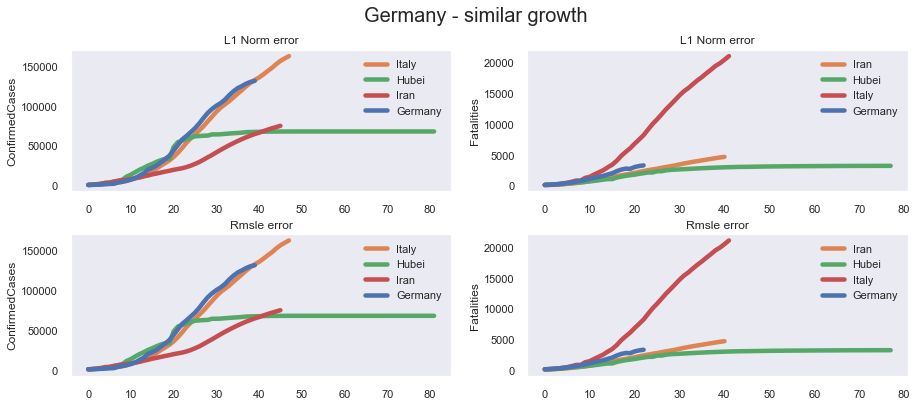

In [13]:
test_metrics(trainData, 'Germany', 500, 100)

#### 1.4.2 Specifc visualizations

In [14]:
def viz_country(trainData, sourceCountry, alignThreshConf, alignThreshDead):
    errorNames = ['RMSLE']
    error      = rmsle_error
    
    r = get_nearest_sequence(trainData, sourceCountry, alignThreshConf, alignThreshDead , error)
    show_country_nn(trainData, sourceCountry, alignThreshConf, alignThreshDead, [r], errorNames)

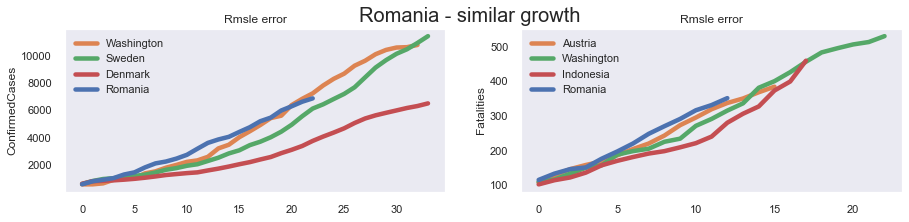

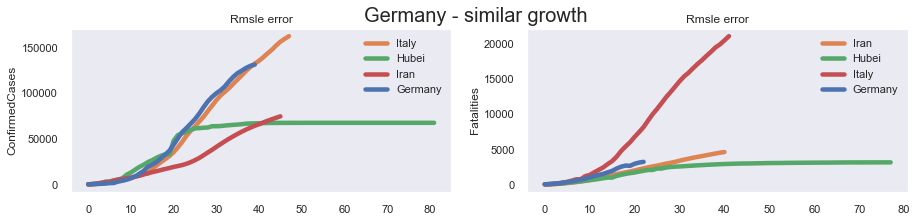

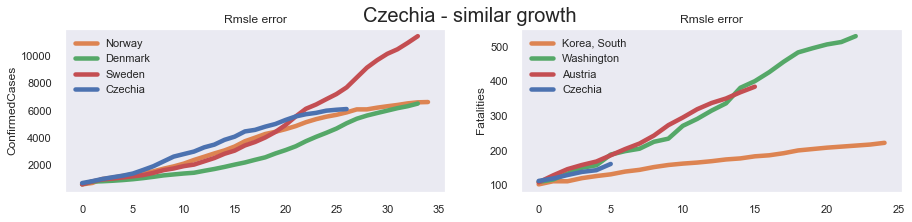

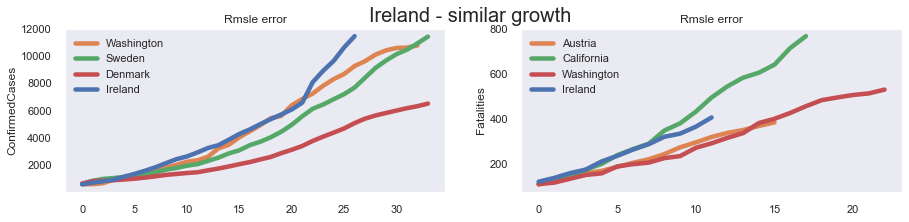

In [15]:
for country in ['Romania', 'Germany','Czechia', 'Ireland']:
    viz_country(trainData, country, 500, 100)

## 2. Predicting

In [16]:
COUNTRY      = 'Romania'
CONF_THRESH  = 400
DEAD_THRESH  = 20
ERROR_MARGIN = 0.5
TRAIN_UP_TO  = pd.to_datetime('2020-04-07')

## 2.1. Country distance

Now, lets build the Error Dataframe. This will be the place where we will store the country similarities and their according error. 

In [17]:
errorDf = get_nearest_sequence(trainData, COUNTRY, CONF_THRESH, DEAD_THRESH , l1_norm_error)
sortConfDf = errorDf.sort_values(by='confirmedError')
sortDeadDf = errorDf.sort_values(by='deathError')

Not that everything is in place, let's see the countries sorted according to the fatalities error and confirmed cases errors.

In [18]:
df1 = sortConfDf.head().style.set_table_attributes("style='display:inline'").set_caption('Sorted by confirmed error')
df2 = sortDeadDf.head().style.set_table_attributes("style='display:inline'").set_caption('Sorted by death error')

display_html(df1._repr_html_()+df2._repr_html_(), raw=True)

,Province_State,deathError,confirmedError,deathIdx,confirmedIdx
28,Washington,0.248099,0.099802,5,1
6,Ecuador,0.096098,0.127123,1,0
19,Sweden,0.544165,0.180502,0,3
14,Japan,0.547804,0.245396,11,15
5,Denmark,0.175756,0.261225,1,8
,Province_State,deathError,confirmedError,deathIdx,confirmedIdx
0,Austria,0.078622,0.636900,0,0
6,Ecuador,0.096098,0.127123,1,0
8,Georgia,0.133996,0.388654,1,0
22,California,0.140893,0.547747,0,0


### 2.2 Confirmed

#### 2.2.1. Data selection

In [19]:
topConfCountries = errorDf.sort_values(by = 'confirmedError')
topConfCountries = topConfCountries[topConfCountries['confirmedError'] < ERROR_MARGIN]
topConfCountries = topConfCountries['Province_State'].values.tolist()
topConfCountries.append(COUNTRY)

In [20]:
targetCols = ['Date', 'Province_State', 'ConfirmedCases']
data       = pd.DataFrame(columns = targetCols)

for country in topConfCountries:
    countryData = trainData[trainData['Province_State'] == country][targetCols]
    countryData = countryData[countryData['ConfirmedCases'] > 0]
    data = pd.concat([data, countryData])
data.describe()

,ConfirmedCases
count,515.000000
mean,1818.409709
std,2729.648336
min,1.000000
25%,28.000000
50%,511.000000
75%,2279.500000
max,14578.000000


Fit scaler

In [21]:
confScaler = StandardScaler()

_dataScaler = data['ConfirmedCases'].values
_dataScaler = _dataScaler.reshape(-1, 1)
confScaler.fit(_dataScaler)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
confirmedTrain = data[data['Date'] <= TRAIN_UP_TO]
confirmedVal = data[data['Date'] > TRAIN_UP_TO]

In [23]:
def batchify(data, device, winSize, step, scaler):
    batches = []
    for c in data['Province_State'].unique():
        cVals = data[data['Province_State'] == c]['ConfirmedCases'].values
        for i in range(0, cVals.shape[0] - winSize, step):
            batch = cVals[i:i+winSize].reshape(-1, 1)
            batch = scaler.transform(batch)
            batches.append(batch)
   
    batches = torch.Tensor(batches).float().to(device)
    return batches

#### 2.1.2 Model 

In [24]:
DEVICE = 'cuda:0'

In [25]:
# build the model
model = BasicRecurrentPredictor(
            # basic parameters
            chNo        = 1,                  # number of input features
            hidChNo     = 128,                # number of RNN cell hidden dimension
            future      = 0,
    
            # rnn cell type and depth
            rnnCell     = 'LSTMCell',         # RNN cell type (just LSTM supported currently)
            rnnNoCells  = 2,                  # no of RNN cells

            # multi layer perceptron that is applied to the output of rnn
            mlpLayerCfg   = [64,64],           # layer hidden dims
            mlpActiv      = 'PReLU',           # inner activation of the mlp
            dropRate      = None,              # dropout rate for each layer of mlp
            normType      = None,              # normalization type
            mlpActivLast  = None,              # note that every timestamp in the sequence will be activated too
            returnFullSeq = True).build()

In [26]:
model.to(DEVICE);
w = WeightInitializer()
w.init_weights(model, 'normal_', {})

#### 2.2.3 Training

In [27]:
WIN_SIZE = 10
OBS_SIZE = 5

In [28]:
criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), 
                        lr             = 0.065, 
                        max_iter       = 50, 
                        tolerance_grad = 1e-7, 
                        history_size   = 75)

In [29]:
confTrainBatch = batchify(confirmedTrain, DEVICE, WIN_SIZE, 1, confScaler)

# shuffle input data
order = np.array(range(confTrainBatch.shape[0]))
np.random.shuffle(order)
confTrainBatch[np.array(range(confTrainBatch.shape[0]))] = confTrainBatch[order]

In [30]:
def closure():
    optimizer.zero_grad()
    
    out  = model(confTrainBatch[:,:OBS_SIZE], future = WIN_SIZE-OBS_SIZE).reshape(-1,WIN_SIZE, 1)
    
    loss = criterion(out, confTrainBatch)
    loss.backward()
#     nn.utils.clip_grad_value_(model.rnnModel.parameters(), 10e+1)
    
    return loss

In [31]:
for i in tqdm(range(10)):
    print('STEP: ', i)    
    loss = optimizer.step(closure)
    print('Loss: ', loss.item())
    
    if torch.isnan(loss):
        raise ValueError('Loss is NaN')

STEP:  0
Loss:  387.3801574707031
STEP:  1
Loss:  0.4211418330669403
STEP:  2
Loss:  0.023091334849596024
STEP:  3
Loss:  0.005693991668522358
STEP:  4
Loss:  0.00418474106118083
STEP:  5
Loss:  0.003903984557837248
STEP:  6
Loss:  0.003628028091043234
STEP:  7
Loss:  0.003407246433198452
STEP:  8
Loss:  0.0033083318267017603
STEP:  9
Loss:  0.002994548762217164



#### 2.2.4 Visualizing results

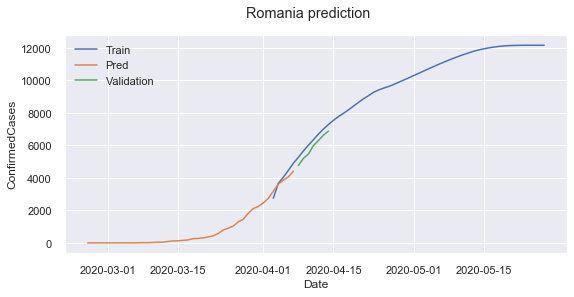

In [32]:
model.eval()

# get figure
fig, ax = plt.subplots(1, 1, figsize = (9, 4))
fig.suptitle(COUNTRY + ' prediction')
ax.grid()
                       

# prepera data for prediction
d = confirmedTrain[confirmedTrain['Province_State'] == COUNTRY] 
dPred = confScaler.transform(d['ConfirmedCases'].values.reshape(-1, 1))
dPred = torch.Tensor(dPred).unsqueeze(0).to(DEVICE)

# make prediction
pred   = model(dPred[:,-OBS_SIZE:], future = 50).cpu().detach().numpy()
pred   = confScaler.inverse_transform(pred[0])

# plot prediction
predDate = pd.date_range(start = d['Date'].values[-OBS_SIZE], periods=pred.shape[0])              
sns.lineplot(y = pred, x = predDate, ax = ax)

# plot train data
dPred = confScaler.inverse_transform(dPred[0].cpu())
sns.lineplot(y = dPred[:, 0], x = d['Date'], ax = ax)

# plot validation
valData = confirmedVal[confirmedVal['Province_State'] == COUNTRY]['ConfirmedCases']
valDate = confirmedVal[confirmedVal['Province_State'] == COUNTRY]['Date']
sns.lineplot(y = valData, x =valDate, ax = ax);

ax.legend(['Train', 'Pred', 'Validation'])
ax.grid()

## 2.3 Fatalities

In [33]:
topDeadCountries = errorDf.sort_values(by = 'deathError')
topDeadCountries = topDeadCountries[topDeadCountries['deathError'] < ERROR_MARGIN]
topDeadCountries = topDeadCountries['Province_State'].values.tolist()
topDeadCountries.append(COUNTRY)

In [34]:
targetColsDead = ['Date', 'Province_State', 'Fatalities']
dataDead       = pd.DataFrame(columns = targetColsDead)

for country in topDeadCountries:
    countryDataDead = trainData[trainData['Province_State'] == country][targetColsDead]
    countryDataDead = countryDataDead[countryDataDead['Fatalities'] > 0]
    dataDead = pd.concat([dataDead, countryDataDead])
data.head()

,Date,Province_State,ConfirmedCases
24156,2020-03-10,Washington,267.0
24157,2020-03-11,Washington,366.0
24158,2020-03-12,Washington,442.0
24159,2020-03-13,Washington,568.0
24160,2020-03-14,Washington,572.0


In [35]:
deadScaler = StandardScaler()

_dataScaleDead = dataDead['Fatalities'].values
_dataScaleDead = _dataScaler.reshape(-1, 1)
deadScaler.fit(_dataScaleDead)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [36]:
deadTrain = dataDead[dataDead['Date'] <= TRAIN_UP_TO]
deadVal   = dataDead[dataDead['Date'] > TRAIN_UP_TO]

In [37]:
def batchify_dead(data, device, winSize, step, scaler):
    batches = []
    for c in data['Province_State'].unique():
        cVals = data[data['Province_State'] == c]['Fatalities'].values
        for i in range(0, cVals.shape[0] - winSize, step):
            batch = cVals[i:i+winSize].reshape(-1, 1)
            batch = scaler.transform(batch)
            batches.append(batch)
   
    batches = torch.Tensor(batches).float().to(device)
    return batches

#### Model

In [47]:
DEVICE = 'cuda:0'

In [48]:
# build the model
modelDead = BasicRecurrentPredictor(
            # basic parameters
            chNo        = 1,                  # number of input features
            hidChNo     = 128,                # number of RNN cell hidden dimension
            future      = 0,
    
            # rnn cell type and depth
            rnnCell     = 'LSTMCell',         # RNN cell type (just LSTM supported currently)
            rnnNoCells  = 2,                  # no of RNN cells

            # multi layer perceptron that is applied to the output of rnn
            mlpLayerCfg   = [64,64],           # layer hidden dims
            mlpActiv      = 'PReLU',           # inner activation of the mlp
            dropRate      = None,              # dropout rate for each layer of mlp
            normType      = None,              # normalization type
            mlpActivLast  = None,              # note that every timestamp in the sequence will be activated too
            returnFullSeq = True).build()

In [49]:
modelDead.to(DEVICE);
w = WeightInitializer()
w.init_weights(modelDead, 'normal_', {})

In [50]:
WIN_SIZE = 10
OBS_SIZE = 5

In [51]:
criterion = nn.MSELoss()
optimizer = optim.LBFGS(modelDead.parameters(), 
                        lr             = 0.065, 
                        max_iter       = 50, 
                        tolerance_grad = 1e-7, 
                        history_size   = 75)

In [52]:
deadTrainBatch = batchify_dead(deadTrain, DEVICE, WIN_SIZE, 1, confScaler)

# shuffle input data
order = np.array(range(deadTrainBatch.shape[0]))
np.random.shuffle(order)
deadTrainBatch[np.array(range(deadTrainBatch.shape[0]))] = deadTrainBatch[order]

In [53]:
def closure_dead():
    optimizer.zero_grad()
    
    out  = modelDead(deadTrainBatch[:,:OBS_SIZE], future = WIN_SIZE-OBS_SIZE).reshape(-1,WIN_SIZE, 1)
    
    loss = criterion(out, deadTrainBatch)
    loss.backward()
#     nn.utils.clip_grad_value_(model.rnnModel.parameters(), 10e+1)
    
    return loss

In [54]:
for i in tqdm(range(10)):
    print('STEP: ', i)    
    loss = optimizer.step(closure_dead)
    print('Loss: ', loss.item())
    
    if torch.isnan(loss):
        raise ValueError('Loss is NaN')

STEP:  0
Loss:  414.670654296875
STEP:  1
Loss:  0.30491992831230164
STEP:  2
Loss:  0.020913129672408104
STEP:  3
Loss:  0.00155447272118181
STEP:  4
Loss:  0.0005256103468127549
STEP:  5
Loss:  8.964616426965222e-05
STEP:  6
Loss:  7.587860454805195e-05
STEP:  7
Loss:  7.142293907236308e-05
STEP:  8
Loss:  6.809538172092289e-05
STEP:  9
Loss:  6.804751319577917e-05



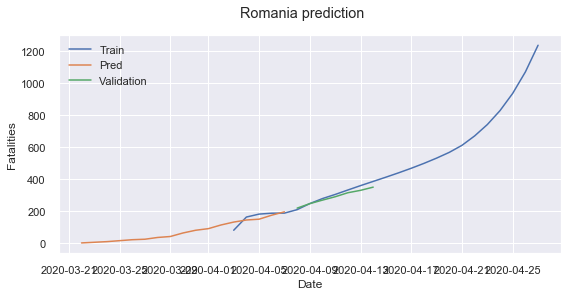

In [57]:
modelDead.eval()

# get figure
fig, ax = plt.subplots(1, 1, figsize = (9, 4))
fig.suptitle(COUNTRY + ' prediction')
ax.grid()
                       

# prepera data for prediction
d = deadTrain[deadTrain['Province_State'] == COUNTRY] 
dPred = deadScaler.transform(d['Fatalities'].values.reshape(-1, 1))
dPred = torch.Tensor(dPred).unsqueeze(0).to(DEVICE)

# make prediction
pred   = modelDead(dPred[:,-OBS_SIZE:], future = 20).cpu().detach().numpy()
pred   = deadScaler.inverse_transform(pred[0])

# plot prediction
predDate = pd.date_range(start = d['Date'].values[-OBS_SIZE], periods=pred.shape[0])              
sns.lineplot(y = pred, x = predDate, ax = ax)

# plot train data
dPred = deadScaler.inverse_transform(dPred[0].cpu())
sns.lineplot(y = dPred[:, 0], x = d['Date'], ax = ax)

# plot validation
valData = deadVal[deadVal['Province_State'] == COUNTRY]['Fatalities']
valDate = deadVal[deadVal['Province_State'] == COUNTRY]['Date']
sns.lineplot(y = valData, x =valDate, ax = ax);

ax.legend(['Train', 'Pred', 'Validation'])
ax.grid()